I should write stuff here

## Notes to self
- I removed clm, numclaims. Only focusing on claimcst0. Is there a way to train the model on clm, numclaims such that it somehow improves the accuracy???
- Alot of the claimcst0 have no values and only a few have non-zero value, is there something we can do here???

### Imports & Global Variables

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# place imports back here

In [34]:
import os, sys
PATH = %pwd
PATH = PATH.split(os.path.sep)
PATH = os.path.sep.join(PATH[:-2]) #removes last 2 directories, gets path to repository

import warnings
warnings.filterwarnings("ignore", "is_sparse")

### Preprocessing

In [35]:
# (1) Read both train/test + validation & preform equal preprocessing on it
df_t = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_train.csv'))
df_t['is_val'] = 0
df_v = pd.read_csv(os.path.join(PATH, 'dataset', 'InsNova_data_2023_vh.csv'))
df_v['is_val'] = 1
total_df = pd.concat([df_t,df_v], ignore_index=True)

In [36]:
# Note
col_categorical = ['veh_body', 'gender', 'area', 'engine_type', 'veh_color', 
                'marital_status', 'time_of_week_driven', 'time_driven']
col_continuous = ['veh_value', 'exposure', 'credit_score']
col_discrete = ['veh_age', 'agecat', 'max_power', 'driving_history_score',
                'e_bill', 'trm_len', 'high_education_ind']

# (2) Feature Manipulation
# (2.1) Continuous/Discrete scaling
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
total_df[col_continuous] = rs.fit_transform(total_df[col_continuous])
total_df[col_discrete] = rs.fit_transform(total_df[col_discrete])

# (2.2) Categorical processing
total_df = pd.get_dummies(data=total_df,columns=col_categorical, dtype=float)

# Replace whitespace with underscore ' ' -> '_'
total_df.columns = total_df.columns.str.replace(' ', '_')

# (3) separate total_df
df_t = total_df[total_df['is_val'] == 0]
df_t = df_t.drop(columns=['is_val','clm','numclaims']) # !removing clm, numclaims
df_v = total_df[total_df['is_val'] == 1]
df_v = df_v.drop(columns='is_val')
del total_df

### Issues
- Imbalanced


In [37]:
claimcst0_percentage = (len(df_t[(df_t['claimcst0'] > 0)])/len(df_t['claimcst0']))*100
print(f"df_t claimcst0 percentage: {claimcst0_percentage}%")

df_t claimcst0 percentage: 6.817277510057916%


In [38]:
df_t_zero = df_t[df_t['claimcst0'] == 0]
df_t_non_0 = df_t[df_t['claimcst0'] > 0]

print(f"zero_shape: {df_t_zero.shape} | non-zero_shape: {df_t_non_0.shape}")

zero_shape: (21077, 54) | non-zero_shape: (1542, 54)


In [39]:
factor = len(df_t_zero)//len(df_t_non_0)
df_t_non_0 = factor * df_t_non_0
train_df = pd.concat([df_t_zero,df_t_non_0], axis=0)

### Model Creation

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

X = train_df.drop(['id','claimcst0'], axis=1)
y = train_df['claimcst0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1,1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1,1)

In [41]:
class Model(nn.Module):
    def __init__(self, num_inputs, num_layers, num_layer_size):
        super().__init__()
        
        self.layers = nn.ModuleList([nn.Linear(num_inputs, num_layer_size)])
        
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_layer_size, num_layer_size))
        
        self.output_layer = nn.Linear(num_layer_size, 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [42]:
class ZeroNonZeroClassifier(nn.Module):
    def __init__(self, num_inputs, num_layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(num_inputs, num_layer_size)])
        self.output_layer = nn.Linear(num_layer_size, 2)  # Output with two classes: zero and non-zero

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

class NonZeroValuePredictor(nn.Module):
    def __init__(self, num_inputs, num_layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(num_inputs, num_layer_size)])
        self.output_layer = nn.Linear(num_layer_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

class Model(nn.Module):
    def __init__(self, num_inputs, num_layers, num_layer_size):
        super().__init__()
        self.zero_nonzero_classifier = ZeroNonZeroClassifier(num_inputs, num_layer_size)
        self.non_zero_value_predictor = NonZeroValuePredictor(num_inputs, num_layer_size)
        self.num_layer_size = num_layer_size

    def forward(self, x):
        classification_output = self.zero_nonzero_classifier(x)
        zero_prob = torch.softmax(classification_output, dim=1)[:, 0]  # Probability of being zero

        non_zero_input = F.relu(x)
        non_zero_output = self.non_zero_value_predictor(non_zero_input)

        final_output = zero_prob.view(-1, 1) * torch.zeros_like(non_zero_output) + (1 - zero_prob).view(-1, 1) * non_zero_output
        return final_output

In [43]:
NUM_EPOCHS = 300
NUM_INPUT_FEATURE = X_train.shape[1]
NUM_LAYERS = 5
NUM_NODES_PER_LAYER = 64
NUM_NO_VAL_LOSS_IMPROVE = 301 #no early termination

model = Model(
    num_inputs=NUM_INPUT_FEATURE,
    num_layers=NUM_LAYERS,
    num_layer_size=NUM_NODES_PER_LAYER
)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [44]:
import math
val_no_improve_counter = 0
best_val_loss = float('inf')

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % math.floor(NUM_EPOCHS * 0.10) == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]\nLoss: {loss.item():.4f}')
        
    #Val
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        if (epoch + 1) % math.floor(NUM_EPOCHS * 0.10) == 0:
            print(f'Validation Loss: {val_loss.item():.4f}\n')

        # Check if the validation loss has increased
        if val_loss > best_val_loss:
            val_no_improve_counter += 1
            if val_no_improve_counter >= NUM_NO_VAL_LOSS_IMPROVE:
                print(f'Early stopping at epoch {epoch+1}. Validation loss stopped improving.')
                break  # Stop training
        else:
            best_val_loss = val_loss
            counter = 0
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

Epoch [30/300]
Loss: 2070.2244
Validation Loss: 2163.3699

Epoch [60/300]
Loss: 1912.4994
Validation Loss: 2003.0033

Epoch [90/300]
Loss: 1775.2211
Validation Loss: 1860.1464

Epoch [120/300]
Loss: 1745.4092
Validation Loss: 1823.0488

Epoch [150/300]
Loss: 1737.6160
Validation Loss: 1813.2635

Epoch [180/300]
Loss: 1733.2383
Validation Loss: 1811.8893

Epoch [210/300]
Loss: 1727.3831
Validation Loss: 1812.9045

Epoch [240/300]
Loss: 1720.8727
Validation Loss: 1816.0017

Epoch [270/300]
Loss: 1714.5458
Validation Loss: 1818.8057

Epoch [300/300]
Loss: 1708.0002
Validation Loss: 1821.5026



In [45]:
with torch.no_grad():
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test)
    
    val_outputs_np = val_outputs.numpy()
    y_test_np = y_test.numpy()
    
    with open(os.path.join(PATH,"src", "NN", "NN_V2_pred-vs-true.txt"), 'w') as f:
        for i in range(len(y_test)):
            f.write(f"Prediction: {val_outputs_np[i][0]:.4f}, True Value: {y_test_np[i][0]:.4f}\n")

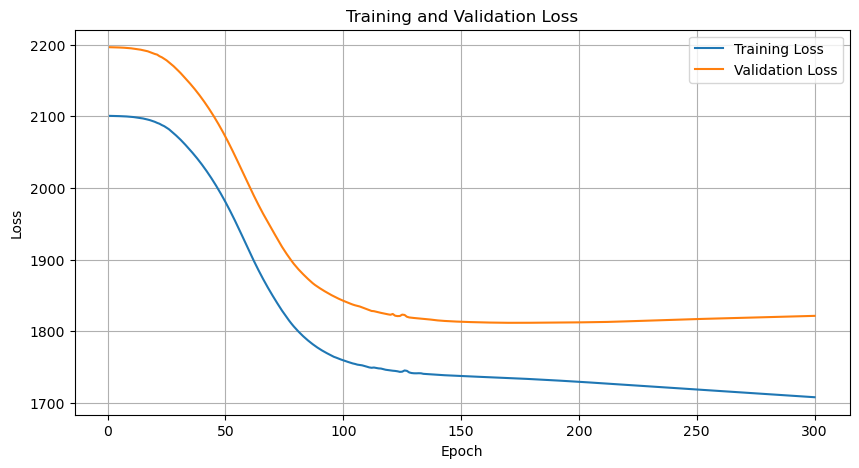

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()